# Custom observation models

While *bayesloop* provides a number of observation models like `Poisson` or `AR1`, many applications call for different distributions, possibly with some parameters set to fixed values (e.g. with a mean value set to zero). The [sympy.stats](http://docs.sympy.org/dev/modules/stats.html) and the [scipy.stats](http://docs.scipy.org/doc/scipy/reference/stats.html) modules include a large number of continuous as well as discrete probability distributions. The observation model class `Custom` allows to create observation models to be used in *bayesloop* studies on-the-fly, just by passing the desired `scipy.stats` distribution (and setting values for fixed parameters, if necessary), or by providing a `sympy.stats` random variable. Note that the `Custom` class can only be used to model statistically independent observations. Locally correlated time series (as described by the `AR1` model) still have to be defined manually by creating a custom class.

## Sympy.stats random variables
The [SymPy](http://www.sympy.org/en/index.html) module introduces symbolic mathematics to Python. Its sub-module [sympy.stats](http://docs.sympy.org/dev/modules/stats.html) covers a wide range of discrete and continuous random variables. In the following, we re-define the observation model of the coal mining study `S` defined above, but this time use the `sympy.stats` version of the poisson distribution:

In [1]:
import bayesloop as bl
import sympy.stats
from sympy import Symbol

lamda = Symbol('lambda', positive=True)
poisson = sympy.stats.Poisson('poisson', lamda)
L = bl.om.Custom(poisson)

+ Creating custom observation model based on random variable from SymPy.
    + Trying to determine Jeffreys prior. This might take a moment...
    + Successfully determined Jeffreys prior: 1/sqrt(lambda)


First, we specify the only parameter of the Poisson distribution (denoted $\lambda$) symbolically as a positive real number. Note that providing the keyword argument `positive=True` is important for `SymPy` to define the Poisson distribution correctly (not setting the keyword argument correctly results in a error). Having defined the parameter, a random variable based on the Poisson distribution is defined. This random variable is then passed to the `Custom` class of the *bayesloop* observation models.

Note that upon creating an instance of the observation model, *bayesloop* automatically determines the correct [Jeffreys prior](https://en.wikipedia.org/wiki/Jeffreys_prior) for the Poisson model:

$$
p(\lambda) \propto 1/\sqrt{\lambda}
$$

This calculation is done symbolically and therefore represents an important advantage of using the `SymPy` module within *bayesloop*. This behavior can be turned off using the keyword argument `determineJeffreysPrior`, in case one wants to use a flat parameter prior instead or in the case that the automatic determination of the prior takes too long:
```
M = bl.om.Custom(poisson, determineJeffreysPrior=False)
```
See also [this tutorial](priordistributions.html) for further information on prior distributions. Having defined the observation model, it can be used for any type of study introduced above. Here, we reproduce the result of the [regime-switching example](changepointstudy.html#Exploring-possible-change-points) we discussed before. We find that the parameter distributions as well as the model evidence is identical - as expected:

+ Created new study.
+ Successfully imported example data.
+ Observation model: Poisson. Parameter(s): ['lambda']
+ Boundaries: [[0, 6]]
+ Grid size: [1000]
+ Transition model: Regime-switching model
+ Started new fit:
    + Formatted data.
    + Finished forward pass.
    + Log10-evidence: -82.86009
    + Finished backward pass.
    + Computed mean parameter values.


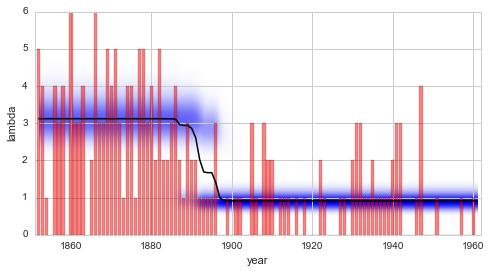

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt # plotting
import seaborn as sns           # nicer plots
sns.set_style('whitegrid')      # plot styling

S = bl.Study()
S.loadExampleData()
S.setObservationModel(bl.om.Poisson())
S.setGrid([[0, 6, 1000]])
S.setTransitionModel(bl.tm.RegimeSwitch(-7))
S.fit()

plt.figure(figsize=(8, 4))
plt.bar(S.rawTimestamps, S.rawData, align='center', facecolor='r', alpha=.5)
S.plotParameterEvolution(param='lambda')
plt.xlim([1851, 1962])
plt.xlabel('year')

Finally, it is important to note that the `SymPy` module can also be used to create random variables for which some parameters have user-defined fixed values. The following example creates a normally distributed random variable with a fixed mean value $\mu = 4$, leaving only the standard deviation as a free parameter of the resulting observation model:
```
mu = 4
std = Symbol('stdev', positive=True)

normal = sympy.stats.Normal('normal', mu, std)
L = bl.om.Custom(normal)
```

## Scipy.stats probability distributions
We continue by describing the use of probability distributions of the `scipy.stats` module. Before we show some usage examples, it is important to note here that `scipy.stats` does not use the canonical parameter names for probability distributions. Instead, all continuous distributions have two parameters denoted `loc` (for shifting the distribution) and `scale` (for scaling the distribution). Discrete distributions only support `loc`. While some distributions may have additional parameters, `loc` and `scale` often take the role of known parameters, like *mean* and *standard deviation* in case of the normal distribution. In `scipy.stats`, you do not have to set `loc` or `scale`, as they have default values `loc=0` and `scale=1`. In *bayesloop*, however, you will have to provide values for these parameters, if you want either of them to be fixed and not treated as a variable.

As a first example, we re-define the observation model of the coal mining study `S` defined above, but this time use the `scipy.stats` version of the poisson distribution. First, we check the parameter names:

In [4]:
import scipy.stats

scipy.stats.poisson.shapes

'mu'

In `scipy.stats`, the rate of events in one time interval of the poisson distribution is called *mu*. Additionally, as a discrete distribution, `stats.poisson` has an additional parameter `loc` (which is **not** shown by `.shapes` attribute!). As we do not want to shift the distribution, we have to set this parameter to zero in *bayesloop* by passing a dictionary for fixed parameters when initializing the class instance:

+ Creating custom observation model based on probability distribution from SciPy.
  ! WARNING: A flat prior is used.
    Automatic determination of Jeffreys priors is only available for SymPy RVs.
+ Observation model: poisson. Parameter(s): ['mu']
+ Started new fit:
    + Formatted data.
    + Finished forward pass.
    + Log10-evidence: -82.71326
    + Finished backward pass.
    + Computed mean parameter values.


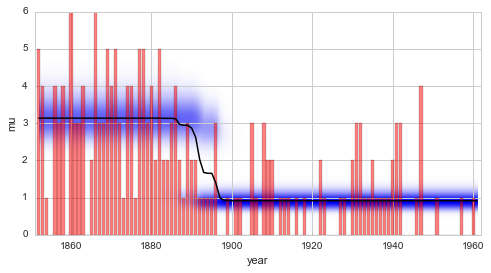

In [5]:
L = bl.observationModels.Custom(scipy.stats.poisson, fixedParameters={'loc': 0})
S.setObservationModel(L)
S.fit()

plt.figure(figsize=(8, 4))
plt.bar(S.rawTimestamps, S.rawData, align='center', facecolor='r', alpha=.5)
S.plotParameterEvolution(param='mu')
plt.xlim([1851, 1962])
plt.xlabel('year')

Comparing this result with the [regime-switching example](changepointstudy.html#Exploring-possible-change-points), we find that the model evidence value obtained using the `scipy.stats` implementation of the Poisson distribution is *different* from the value obtained using the built-in implementation or the `sympy.stats` version. The deviation is explained by a different prior distribution for the parameter $\lambda$. While both the built-in version and the `sympy.stats` version use the [Jeffreys prior](https://en.wikipedia.org/wiki/Jeffreys_prior) of the Poisson model, the `scipy.stats` implementation uses a flat prior instead. Since the `scipy.stats` module does not provide symbolic representations of probability distributions, *bayesloop* cannot determine the correct Jeffreys prior in this case.

Finally, note that using the `scipy.stats` classes may increase the analysis run time slightly, compared to the built-in observation models.